In [48]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
# make df with column names year, month, decimal date, SSN, M1, M2, M3, M4, M5 from file 5c_obs_sim_v1.dat
df = pd.read_csv('5c_obs_sim_v1.dat', sep='\s+', header=None, names=['year', 'month', 'decimal_date', 'SSN', 'M1', 'M2', 'M3', 'M4', 'M5'])
    

In [50]:
df.head()

,year,month,decimal_date,SSN,M1,M2,M3,M4,M5
0,1965,1,1965.042,17.2,0.0,0.0,0.0,1.074928,0.118900
1,1965,2,1965.123,17.7,0.0,0.0,0.0,1.359678,0.279050
2,1965,3,1965.204,18.4,0.0,0.0,0.0,1.809270,0.321381
3,1965,4,1965.288,19.9,0.0,0.0,0.0,2.395858,0.408844
4,1965,5,1965.371,21.2,0.0,0.0,0.0,3.147034,0.521735


In [51]:
import plotly.graph_objects as go

# Assuming df is your DataFrame

fig = go.Figure()

# Add SSN scatter plot
fig.add_trace(go.Scatter(x=df['decimal_date'], y=df['SSN'], name='SSN'))

# Add M1-M5 scatter plots
for i in range(1, 6):
    fig.add_trace(go.Scatter(x=df['decimal_date'], y=df[f'M{i}'], name=f'M{i}', visible=True))

# make yrange from 0 to 250
fig.update_yaxes(range=[-20, 250])
# Show figure
fig.show()

In [94]:
MODEL_SERIES_INPUT_SIZE = 4
OBSERVED_SERIES_INPUT_SIZE = 4

class MixedDataGenerator:
    def __init__(self,
                 model_series,
                 observed_series,
                 model_series_input_size=MODEL_SERIES_INPUT_SIZE,
                 observed_series_input_size=OBSERVED_SERIES_INPUT_SIZE):
        self.model_series = model_series
        self.observed_series = observed_series
        self.model_series_input_size = model_series_input_size
        self.observed_series_input_size = observed_series_input_size
        self.X, self.y = self._prepare_data()
        
    def _prepare_data(self):
        l = len(self.model_series) - self.model_series_input_size - self.observed_series_input_size
        X = np.zeros((l, self.model_series_input_size + self.observed_series_input_size))
        y = np.zeros(l)
        for i in range(l):
            X[i, :self.model_series_input_size] = self.model_series[i:i + self.model_series_input_size]
            X[i, self.model_series_input_size:] = self.observed_series[i:i + self.observed_series_input_size]
            y[i] = self.observed_series[i + self.model_series_input_size + self.observed_series_input_size]
        # normalize max
        y = y / np.max(y)
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [95]:
model_series = df['M1'].values
observed_series = df['SSN'].values

data = MixedDataGenerator(model_series, observed_series)

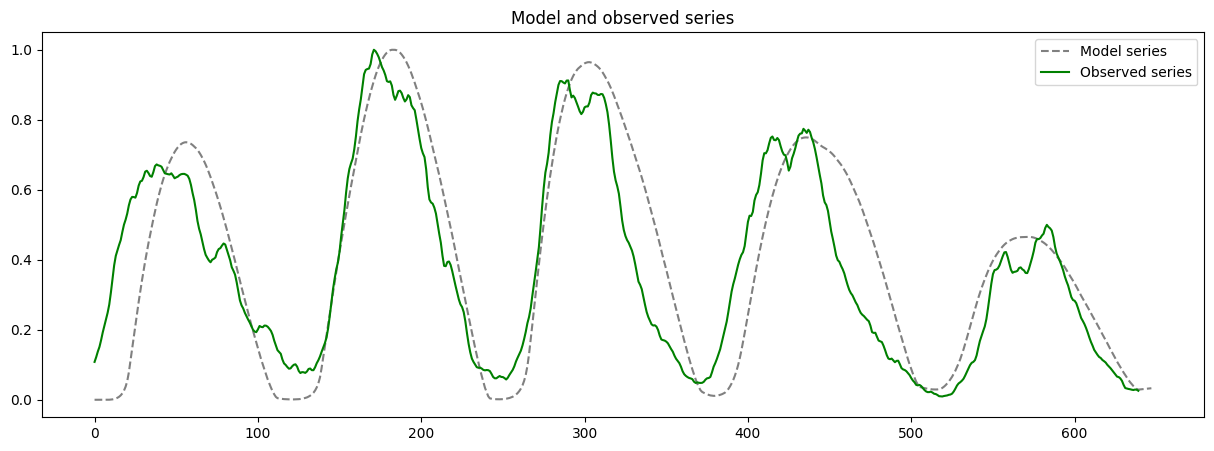

In [96]:
# plot
plt.figure(figsize=(15, 5))
plt.plot(model_series / np.max(model_series), label='Model series', linestyle='--', color='gray')
plt.plot(data.y, label='Observed series', color='green')
plt.legend()
plt.title('Model and observed series')
plt.show()

In [97]:
# define the NARX model
class NARX(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NARX, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        
    def forward(self, x):
        out = torch.tanh(self.fc1(x))
        out = torch.sigmoid(self.fc2(out))
        return out
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [98]:
model = NARX(input_size=MODEL_SERIES_INPUT_SIZE + OBSERVED_SERIES_INPUT_SIZE, hidden_size=64, output_size=1)

In [99]:
def train_model(model, epochs=100, learning_rate=0.001, data=data):
    train_data_X, test_data_X, train_data_y, test_data_y = train_test_split(data.X, data.y, test_size=0.4, shuffle=False)
    val_data_X, test_data_X, val_data_y, test_data_y = train_test_split(test_data_X, test_data_y, test_size=0.5, shuffle=False)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)

    train_losses = []
    val_losses = []
    train_data_X = train_data_X.to(device)
    train_data_y = train_data_y.to(device)
    val_data_X = val_data_X.to(device)
    val_data_y = val_data_y.to(device)

    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()

        outputs = model(train_data_X)
        loss = criterion(outputs.squeeze(), train_data_y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        model.eval()
        val_outputs = model(val_data_X)
        val_loss = criterion(val_outputs.squeeze(), val_data_y)
        val_losses.append(val_loss.item())

    return train_losses, val_losses


In [100]:

train_losses, val_losses = train_model(model, epochs=1000, learning_rate=0.001, data=data)


100%|██████████| 1000/1000 [00:02<00:00, 408.40it/s]


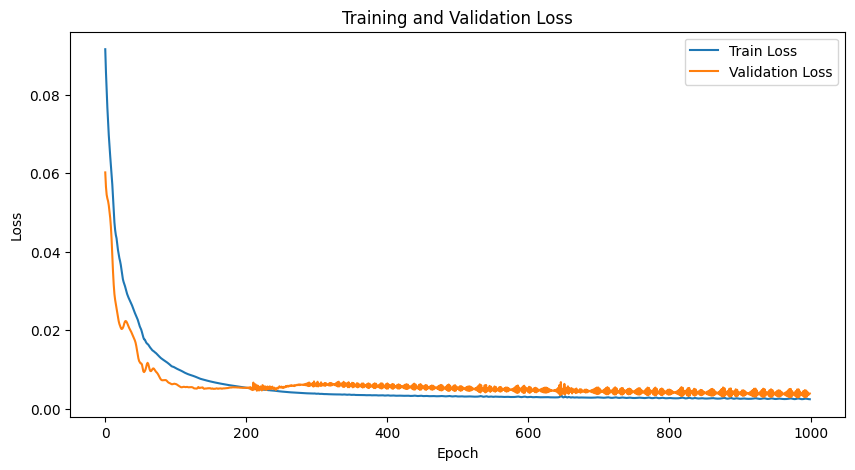

In [101]:
# График потерь
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

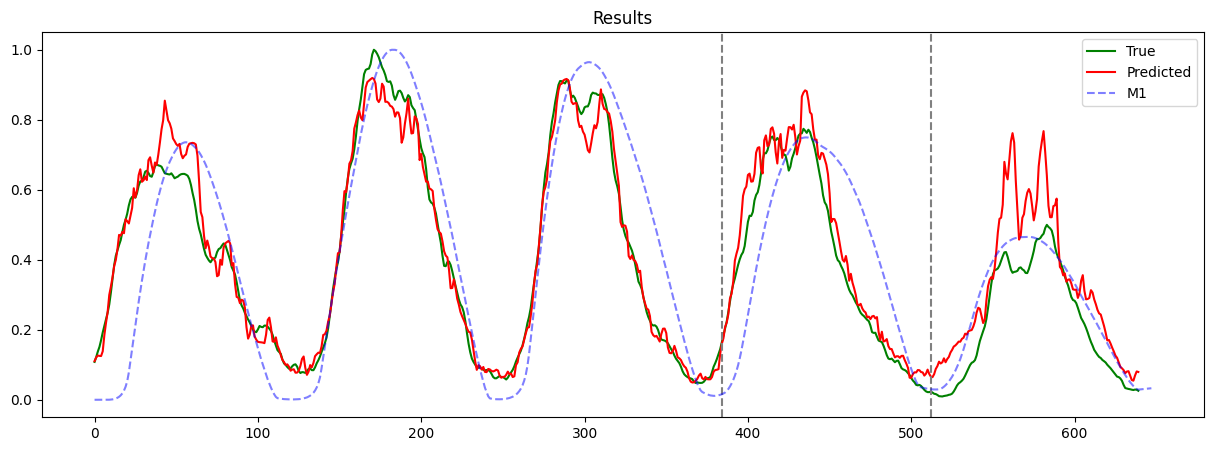

In [102]:
# График предсказаний на обучении
model.eval()
train_data_X = data.X.to(device)
train_data_y = data.y.to(device)
train_outputs = model(train_data_X)
plt.figure(figsize=(15, 5))
plt.plot(train_data_y.cpu(), label='True', color='green')
plt.plot(train_outputs.detach().cpu(), label='Predicted', color='red')
# train-val line
plt.axvline(x=0.6 * len(train_data_X), color='gray', linestyle='--')
plt.axvline(x=0.8 * len(train_data_X), color='gray', linestyle='--')
# add M1
plt.plot(model_series / np.max(model_series), label='M1', linestyle='--', color='blue', alpha=0.5)
plt.title('Results')
plt.legend()
plt.show()

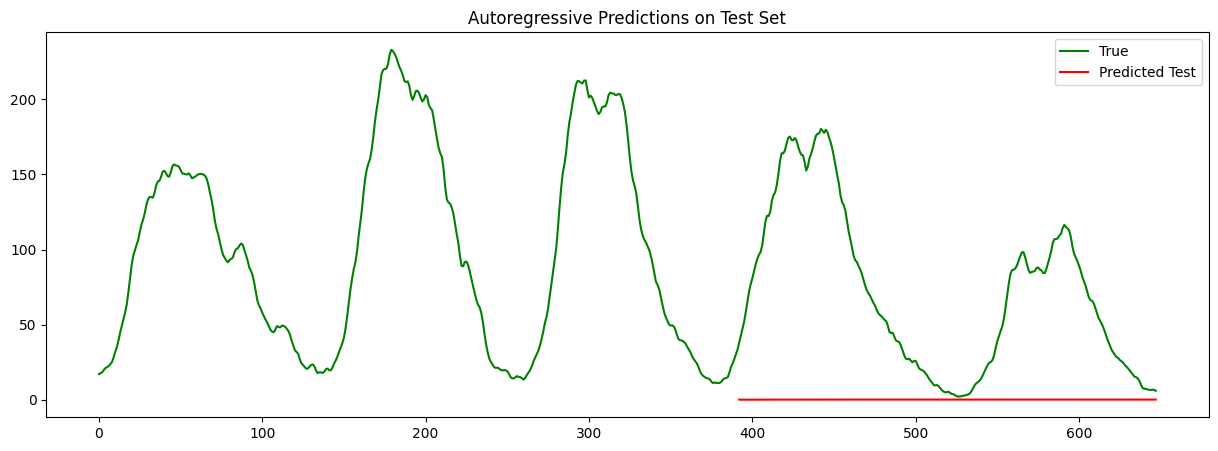

In [103]:
# Функция для предсказания на тестовой выборке автрекрессионно
def predict_autoregressive(model, model_series, observed_series, test_size):
    model.eval()
    input_size = MODEL_SERIES_INPUT_SIZE + OBSERVED_SERIES_INPUT_SIZE
    predictions = []

    # Используем последние значения из тренировочного набора и первые из тестового набора
    observed_series = list(observed_series)
    model_series = list(model_series)
    
    for i in range(test_size):
        # Формируем входной вектор
        model_input = model_series[-MODEL_SERIES_INPUT_SIZE:]
        observed_input = observed_series[-OBSERVED_SERIES_INPUT_SIZE:]
        input_vector = np.concatenate((model_input, observed_input))
        input_tensor = torch.tensor(input_vector, dtype=torch.float32).unsqueeze(0).to(device)
        
        # Получаем предсказание
        with torch.no_grad():
            predicted_value = model(input_tensor).cpu().item()
        
        # Добавляем предсказание в список
        predictions.append(predicted_value)
        
        # Обновляем входные данные
        observed_series.append(predicted_value)
        model_series.append(model_series[-1] + 1)  # Предполагаем, что модельный ряд увеличивается на 1 каждый шаг

    return predictions

# Пример использования на тестовой выборке
train_data_X, test_data_X, train_data_y, test_data_y = train_test_split(data.X, data.y, test_size=0.4, shuffle=False)
test_size = len(test_data_y)
future_predictions = predict_autoregressive(model, model_series[:len(model_series)-test_size], observed_series[:len(observed_series)-test_size], test_size)

# График предсказаний на тестовой выборке
plt.figure(figsize=(15, 5))
plt.plot(np.arange(len(observed_series)), observed_series, label='True', color='green')
plt.plot(np.arange(len(observed_series) - test_size, len(observed_series)), future_predictions, label='Predicted Test', color='red')
plt.title('Autoregressive Predictions on Test Set')
plt.legend()
plt.show()


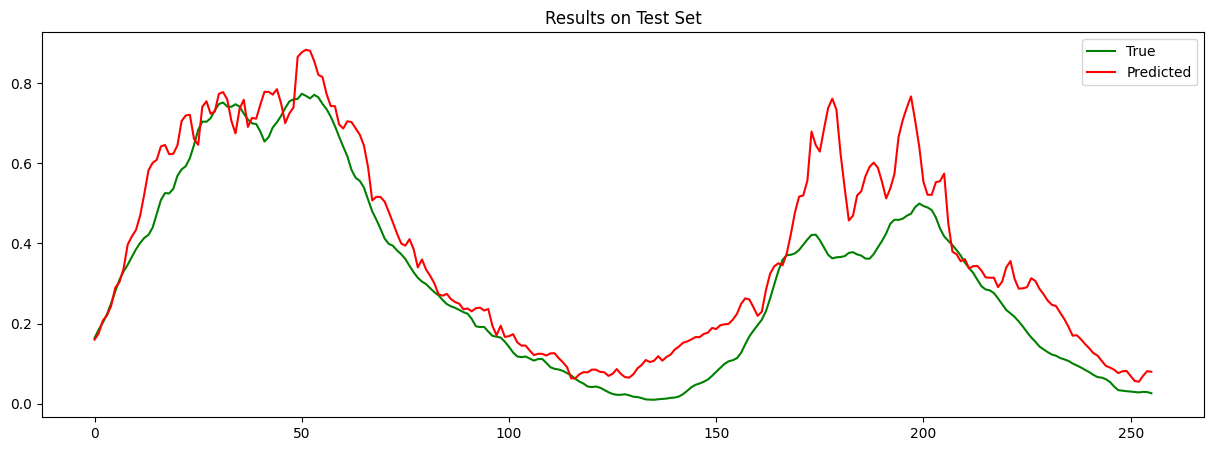

In [104]:
# make predictions on test set
model.eval()
test_data_X = test_data_X.to(device)
test_data_y = test_data_y.to(device)
test_outputs = model(test_data_X)

# plot predictions on test set
plt.figure(figsize=(15, 5))
plt.plot(test_data_y.cpu(), label='True', color='green')
plt.plot(test_outputs.detach().cpu(), label='Predicted', color='red')
plt.title('Results on Test Set')
plt.legend()
plt.show()
